Dataset of full experimental library of 160,000 variants of RH. Fitness measures binding of RH to ERE and SRE separately. Genetic backgrounds (wild type) are AncSR1 and AncSR1+11P.

Thus there are four separate datasets split into two pickle files based on genetic background.

Preprocessed like the phoq, GB1 datasets.

In [1]:
import itertools
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')
sns.set_context('paper')
# Plot adjustments:
plt.rcParams.update({'ytick.labelsize': 15})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'axes.labelsize': 35})
plt.rcParams.update({'legend.fontsize': 30})
plt.rcParams.update({'axes.titlesize': 16})

from gpmodel import gpmodel, gpkernel, gptools, chimera_tools

In [2]:
df = pd.read_csv('../inputs/ANCSR1_FITNESS.csv')
variants = df['AAseq'].values
ERE_fit = df['ERE mean fluorescence'].values
SRE_fit = df['SRE mean fluorescence'].values

In [3]:
df = pd.read_csv('../inputs/ANCSR1_11P_FITNESS.csv')
ERE_fit_11P = df['ERE mean fluorescence'].values
SRE_fit_11P = df['SRE mean fluorescence'].values

In [4]:
# Change nan values to 1e-5
for i, e in enumerate(ERE_fit):
    if np.isnan(e):
        ERE_fit[i] = 1e-5
        
for i, e in enumerate(SRE_fit):
    if np.isnan(e):
        SRE_fit[i] = 1e-5
        
for i, e in enumerate(ERE_fit_11P):
    if np.isnan(e):
        ERE_fit_11P[i] = 1e-5
        
for i, e in enumerate(SRE_fit_11P):
    if np.isnan(e):
        SRE_fit_11P[i] = 1e-5

In [5]:
ERE_nan = [i for i in ERE_fit if np.isnan(i)]
SRE_nan = [i for i in SRE_fit if np.isnan(i)]
ERE_nan_11P = [i for i in ERE_fit_11P if np.isnan(i)]
SRE_nan_11P = [i for i in SRE_fit_11P if np.isnan(i)]
print(len(ERE_nan), len(SRE_nan), len(ERE_nan_11P), len(SRE_nan_11P))

0 0 0 0


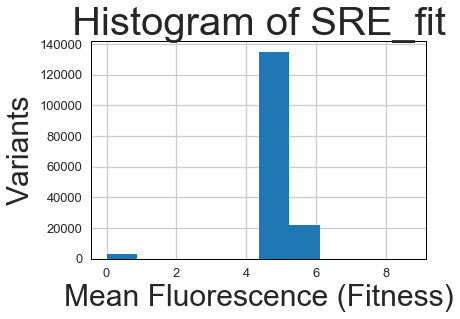

In [6]:
# matplotlib histogram
_ = plt.hist(SRE_fit)

# Add labels
_ = plt.title('Histogram of SRE_fit')
_ = plt.xlabel('Mean Fluorescence (Fitness)')
_ = plt.ylabel('Variants')

In [7]:
# take log of fitness
log_ERE_fit = np.log10(ERE_fit)
log_SRE_fit = np.log10(SRE_fit)
log_ERE_fit_11P = np.log10(ERE_fit_11P)
log_SRE_fit_11P = np.log10(SRE_fit_11P)

In [8]:
d = {'Variants': [], 'ERE Fitness (AncSR1)': [], 'SRE Fitness (AncSR1)': [],
     'ERE Fitness (AncSR1+11P)': [], 'SRE Fitness (AncSR1+11P)': []}

for v, f1, f2, f3, f4 in zip(variants, log_ERE_fit, log_SRE_fit, log_ERE_fit_11P, log_SRE_fit_11P):
    d['Variants'].append(v)
    d['ERE Fitness (AncSR1)'].append(f1)
    d['SRE Fitness (AncSR1)'].append(f2)
    d['ERE Fitness (AncSR1+11P)'].append(f3)
    d['SRE Fitness (AncSR1+11P)'].append(f4)
    
df = pd.DataFrame(data=d) # make dataframe of sampled ys to plot on swarmplot

In [9]:
def make_Xs(df):
    """ Make sure df has the index you want for the Xs"""
    contacts = list(itertools.combinations((0, 1, 2, 3), 2))

    amino_acids = 'ARNDCQEGHILKMFPSTWYV'

    sample_space = [amino_acids for _ in range(len(df.iloc[0]['Variants']))]
    seq_terms = chimera_tools.make_sequence_terms(sample_space)
    struct_terms = chimera_tools.contacting_terms(sample_space, contacts)
    all_terms = seq_terms + struct_terms
 
    seqs = df['Variants'].values
    struct_X, _ = chimera_tools.make_contact_X(seqs, None, contacts,
                                               contact_terms=struct_terms)
    seq_X, _ = chimera_tools.make_sequence_X(seqs, sample_space=sample_space,
                                             sequence_terms=seq_terms)
    #all_X = np.concatenate([seq_X, struct_X], axis=1)
    X_dumb = np.zeros((len(df), len(df.iloc[0]['Variants'])))
    aa = np.array(sorted(amino_acids))
    for i, seq in enumerate(seqs):
        for j, s in enumerate(seq):
            X_dumb[i, j] = np.argwhere(aa == s).flatten()

    return seq_X, X_dumb

X, T = make_Xs(df)
y_ERE = df.loc[:, 'ERE Fitness (AncSR1)']
y_SRE = df.loc[:, 'SRE Fitness (AncSR1)']
y_ERE_11P = df.loc[:, 'ERE Fitness (AncSR1+11P)']
y_SRE_11P = df.loc[:, 'SRE Fitness (AncSR1+11P)']

In [10]:
wt_ind = np.argwhere(variants == "GSKV")[0][0] # the historical outcome
wt_ind

46177

In [11]:
df_aa = pd.read_csv('../inputs/aaindex_cosine_64.txt', index_col=0)
mus = np.expand_dims(np.mean(df_aa, axis=1).values, 1)
var = np.expand_dims(np.std(df_aa, axis=1).values, 1)
aa = pd.DataFrame((df_aa.values - mus) / var, index=df_aa.index, columns=df_aa.columns)
X_aa = np.array([np.array([aa[s].values for s in seq]).flatten() for seq in df.loc[:, 'Variants'].values])
X_aa = pd.DataFrame(X_aa, index=df.index)
X_aa.shape

(160000, 256)

In [12]:
with open('../inputs/AncSR1.pkl', 'wb') as f:
    pickle.dump((X, T, X_aa.values, y_ERE, y_SRE, wt_ind), f)

In [13]:
with open('../inputs/AncSR1+11P.pkl', 'wb') as f:
    pickle.dump((X, T, X_aa.values, y_ERE_11P, y_SRE_11P, wt_ind), f)